In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from IPython.display import Image
import scipy.stats as stats

from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
from pgmpy.estimators import MmhcEstimator, HillClimbSearch, BdeuScore, K2Score, BicScore, ConstraintBasedEstimator
import networkx as nx

%matplotlib inline

In [2]:
data = pd.read_csv('../data/so.csv')
data = data[data.gender.isin(['Male', 'Female', 'Other'])]

data = data.dropna(subset=['salary_range'])
data = data[data['salary_range'].str.contains('\$')]
data['desktop_os'] = data['desktop_os'].str.replace('Ubuntu|Debian|Fedora|Mint|Other Linux', 'Linux')
data['desktop_os'] = data['desktop_os'].str.replace('Windows.*', 'Windows')
data['is_javascript'] = data['tech_do'].str.contains('JavaScript').apply(lambda x: str(x) if not x == np.nan else np.nan)
data['is_php'] = data['tech_do'].str.contains('PHP').apply(lambda x: str(x) if not x == np.nan else np.nan)
data['is_python'] = data['tech_do'].str.contains('Python').apply(lambda x: str(x) if not x == np.nan else np.nan)
data['salary_range'] = data.salary_range.str.replace('\$[0-9]{3},000 - \$[0-9]{3},000', 'More than $100,000')
data['salary_range'] = data.salary_range.str.replace('More than \$200,000', 'More than $100,000')
data = data[['age_range', 'star_wars_vs_star_trek', 'experience_range', 
            'salary_range', 'gender', 'so_region', 'agree_diversity',
            'is_javascript', 'is_php', 'is_python', 'desktop_os']]
def ev(dictionary):
    return {k: list(data[k].unique()).index(v) for k,v in dictionary.items()}

In [3]:
data.head()

,age_range,star_wars_vs_star_trek,experience_range,salary_range,gender,so_region,agree_diversity,is_javascript,is_php,is_python,desktop_os
1,30-34,Star Wars,6 - 10 years,"$40,000 - $50,000",Male,Central Asia,Agree somewhat,False,False,False,Mac OS X
3,NaN,NaN,11+ years,"Less than $10,000",Female,Central Asia,Agree somewhat,nan,nan,nan,Linux
6,Prefer not to disclose,NaN,11+ years,"More than $100,000",Other,Central Asia,NaN,True,True,True,Windows
7,25-29,NaN,1 - 2 years,"Less than $10,000",Male,Central Asia,Disagree completely,True,True,False,Windows
9,20-24,NaN,1 - 2 years,"Less than $10,000",Male,Eastern Europe,Agree somewhat,False,True,False,Windows


In [11]:
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BdeuScore, K2Score, BicScore

np.random.seed(42)

hc = HillClimbSearch(data, scoring_method=BicScore(data))
best_model = hc.estimate()
print(best_model.edges())

[('age_range', 'star_wars_vs_star_trek'), ('gender', 'agree_diversity'), ('experience_range', 'gender'), ('experience_range', 'age_range'), ('is_javascript', 'is_php'), ('is_python', 'is_javascript'), ('is_python', 'desktop_os'), ('desktop_os', 'so_region'), ('salary_range', 'experience_range'), ('salary_range', 'is_php'), ('so_region', 'salary_range')]


In [5]:
def draw_graph(model):
    G = nx.DiGraph()
    G.add_nodes_from(data.columns)
    G.add_edges_from(model.edges())

    plt.figure(figsize=(10, 10))
    layout = nx.fruchterman_reingold_layout(G)
    nx.draw(G, pos=layout, with_labels=True, alpha=0.2, arrows=True)

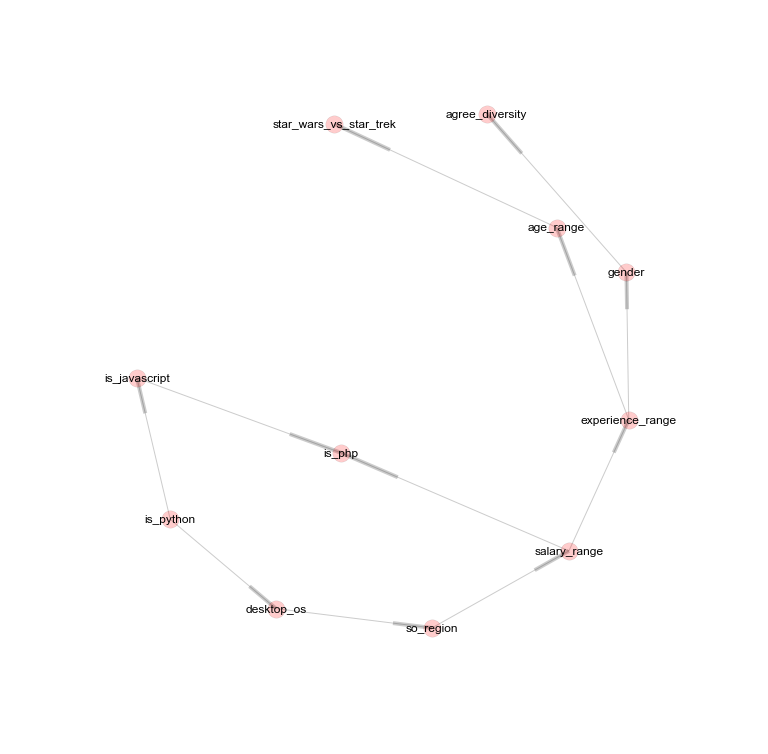

In [10]:
draw_graph(best_model)

('Undirected edges: ', [('age_range', 'experience_range'), ('age_range', 'salary_range'), ('age_range', 'so_region'), ('is_php', 'is_javascript'), ('gender', 'agree_diversity'), ('experience_range', 'salary_range'), ('experience_range', 'so_region'), ('is_javascript', 'is_python'), ('is_python', 'desktop_os'), ('salary_range', 'so_region')])
('PDAG edges:       ', [('age_range', 'salary_range'), ('age_range', 'experience_range'), ('age_range', 'so_region'), ('is_php', 'is_javascript'), ('gender', 'agree_diversity'), ('experience_range', 'salary_range'), ('experience_range', 'age_range'), ('experience_range', 'so_region'), ('is_javascript', 'is_php'), ('is_javascript', 'is_python'), ('desktop_os', 'is_python'), ('salary_range', 'age_range'), ('salary_range', 'so_region'), ('salary_range', 'experience_range'), ('so_region', 'salary_range'), ('so_region', 'age_range'), ('so_region', 'experience_range'), ('agree_diversity', 'gender')])
('DAG edges:        ', [('experience_range', 'age_rang

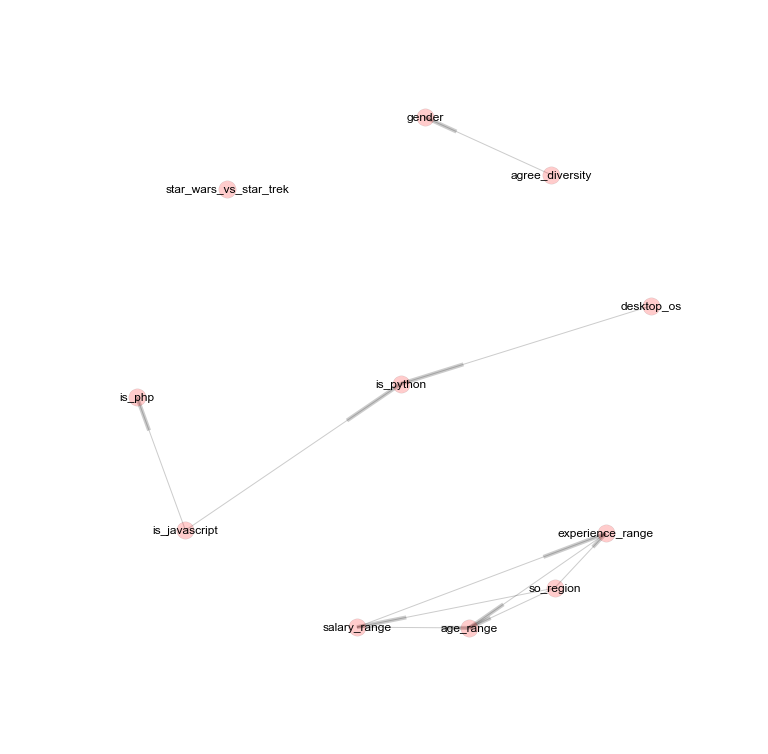

In [15]:
np.random.seed(42)
est = ConstraintBasedEstimator(data)
skel, seperating_sets = est.estimate_skeleton(significance_level=0.001)
print("Undirected edges: ", skel.edges())

pdag = est.skeleton_to_pdag(skel, seperating_sets)
print("PDAG edges:       ", pdag.edges())

model = est.pdag_to_dag(pdag)
print("DAG edges:        ", model.edges())

draw_graph(model)

In [18]:
bic = BicScore(data)
k2 = K2Score(data)
bdeu = BdeuScore(data, equivalent_sample_size=5)
print('K2: ', k2.score(model))
print('BIC', bic.score(model))
print('Bdeu', bdeu.score(model))

('K2: ', -322914.0673207193)
('BIC', -350620.47821670427)
('Bdeu', -329743.765572083)


C:\Anaconda2\lib\site-packages\pgmpy\estimators\base.py:202: UserWarning: Insufficient data for testing age_range _|_ is_php | ['so_region', 'salary_range', 'experience_range']. At least 57200 samples recommended, 41233 present.
  "At least {0} samples recommended, {1} present.".format(5 * num_params, len(self.data)))
C:\Anaconda2\lib\site-packages\pgmpy\estimators\base.py:202: UserWarning: Insufficient data for testing age_range _|_ gender | ['so_region', 'salary_range', 'experience_range']. At least 57200 samples recommended, 41233 present.
  "At least {0} samples recommended, {1} present.".format(5 * num_params, len(self.data)))
C:\Anaconda2\lib\site-packages\pgmpy\estimators\base.py:202: UserWarning: Insufficient data for testing age_range _|_ star_wars_vs_star_trek | ['so_region', 'salary_range', 'experience_range']. At least 57200 samples recommended, 41233 present.
  "At least {0} samples recommended, {1} present.".format(5 * num_params, len(self.data)))
C:\Anaconda2\lib\site-pa

('Part 1) Skeleton: ', [('age_range', 'salary_range'), ('age_range', 'experience_range'), ('age_range', 'so_region'), ('age_range', 'star_wars_vs_star_trek'), ('is_php', 'is_javascript'), ('gender', 'experience_range'), ('experience_range', 'salary_range'), ('experience_range', 'so_region'), ('is_javascript', 'is_python'), ('is_python', 'desktop_os'), ('desktop_os', 'agree_diversity'), ('salary_range', 'so_region')])
('Part 2) Model:    ', [('age_range', 'salary_range'), ('age_range', 'star_wars_vs_star_trek'), ('gender', 'experience_range'), ('experience_range', 'age_range'), ('is_javascript', 'is_php'), ('is_javascript', 'is_python'), ('is_python', 'desktop_os'), ('desktop_os', 'agree_diversity'), ('salary_range', 'so_region')])


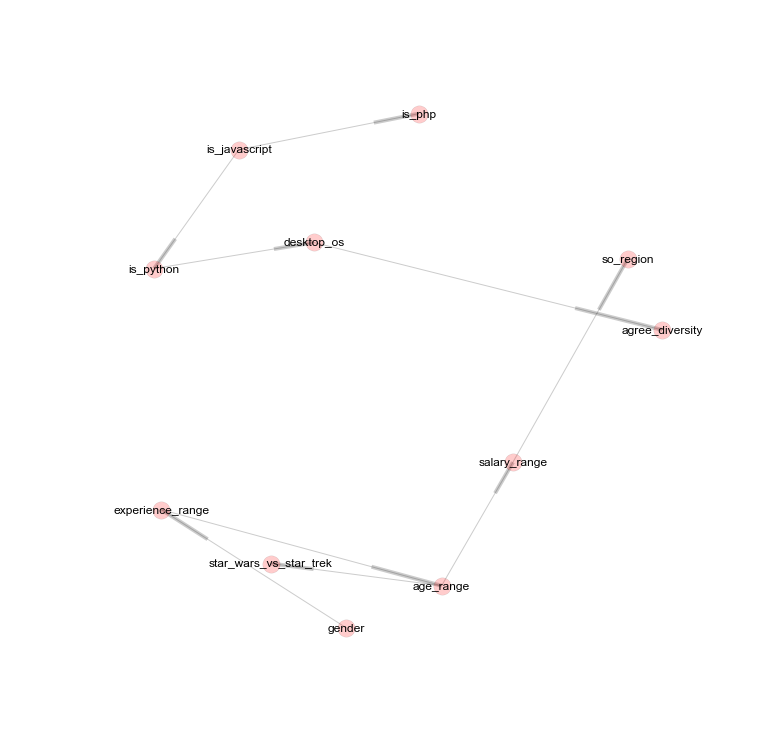

In [21]:
np.random.seed(42)
#mmhc = MmhcEstimator(data)
#skeleton = mmhc.mmpc()
import pickle
#with open('model.pkl', 'wb') as file:
#    pickle.dump(skeleton, file)

with open('model.pkl', 'rb') as file:
    skeleton = pickle.load(file)
print("Part 1) Skeleton: ", skeleton.edges())

# use hill climb search to orient the edges:
hc = HillClimbSearch(data, scoring_method=BdeuScore(data))
model = hc.estimate(tabu_length=10, white_list=skeleton.to_directed().edges())
print("Part 2) Model:    ", model.edges())
draw_graph(model)

In [20]:
bic = BicScore(data)
k2 = K2Score(data)
bdeu = BdeuScore(data, equivalent_sample_size=5)
print('K2: ', k2.score(model))
print('BIC', bic.score(model))
print('Bdeu', bdeu.score(model))

('K2: ', -321298.395859321)
('BIC', -321886.0147573023)
('Bdeu', -321570.5686682096)


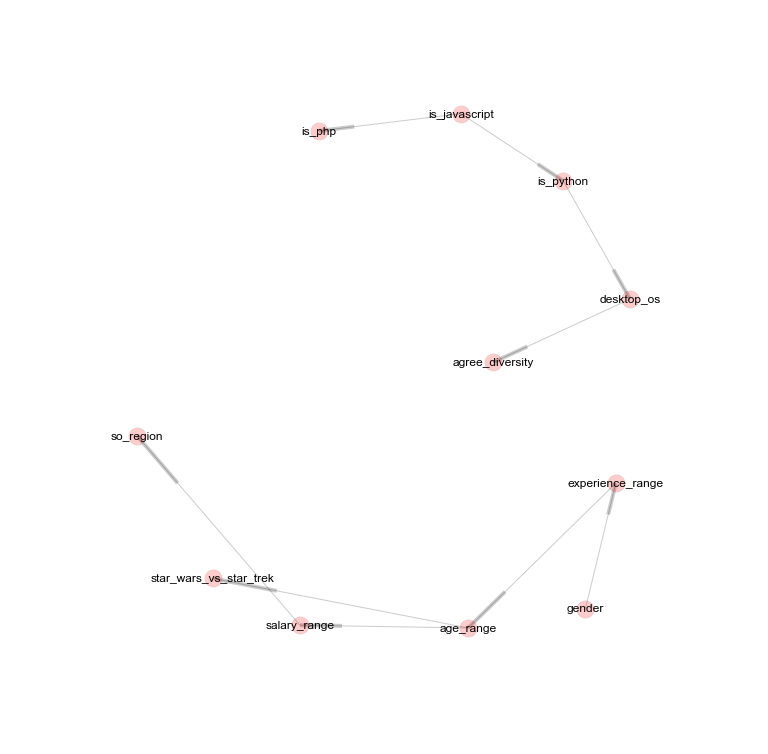

In [9]:
draw_graph(model)